# Régularisation


Dans ce cours sur le deep learning, on a vu que les réseaux de neurones sont très efficaces pour résoudre divers problèmes. Cependant, certains problèmes majeurs limitent leur potentiel. Aujourd'hui, on va parler de l'*overfitting*.

L'*overfitting* se produit quand le modèle s'adapte trop précisément aux données d'entraînement, en captant même les anomalies et le bruit. Résultat, ses performances sur les données de test sont mauvaises.

![Overfitting](./images/overfitting.png)

Ce problème est courant lors de l'entraînement des réseaux de neurones. Pour le surveiller, on utilise un jeu de données de validation qu'on évalue régulièrement pour vérifier que le *loss* diminue bien. En cas d'*overfitting*, les courbes de *loss* d'entraînement et de validation ressemblent à ceci :

![Overfitting Curve](./images/overfittingcurve.png)

Le *loss* d'entraînement continue de diminuer, tandis que le *loss* de validation augmente. Cela montre que le modèle apprend les spécificités des données d'entraînement, ce qui est l'inverse de ce qu'on veut.

En y réfléchissant, c'est logique : le modèle essaie de minimiser le *loss* sur les données d'entraînement.

C'est un point crucial à considérer lors de l'entraînement d'un réseau de neurones. Pour lutter contre ce problème, plusieurs techniques existent. On va en présenter deux ici, en essayant de comprendre pourquoi elles fonctionnent.

Ces deux méthodes sont la **régularisation-L2** et le ***dropout***. Ce notebook s'inspire du [cours de fastai](https://github.com/fastai/fastbook/tree/master).


## Régularisation-L2


La régularisation L2 est une technique simple. Elle consiste à ajouter la somme des poids au carré à la fonction de *loss* (avec un facteur $wd$ appelé *weight_decay*). Ce terme dans la fonction de *loss* pousse les poids à être les plus petits possible.


### Pourquoi ça réduit l'overfitting ?


Intuitivement, des poids plus importants peuvent créer des pentes plus abruptes dans la fonction de *loss*.

Pour confirmer cette intuition, regardons ce qui se passe avec la fonction parabole :
$y=a \times x²$


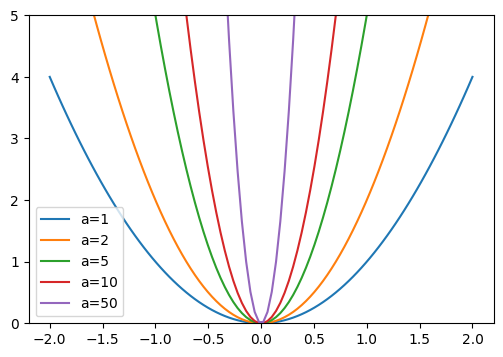

In [2]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(6,4))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

Plus $a$ augmente, plus la parabole devient abrupte. Si on compare $a$ à nos poids, on peut imaginer que des poids importants conduisent à une fonction représentée par un réseau avec des changements abrupts, ce qui peut correspondre à de l'*overfitting*.

Cette justification peut sembler un peu "magique", mais en pratique, la régularisation-L2 a vraiment un impact positif pour prévenir l'*overfitting*.

Limiter la valeur des poids réduit aussi la capacité d'apprentissage du réseau. Mais cette limitation permet une meilleure généralisation et évite l'*overfitting*.


### Implémentation de la méthode


Pour implémenter la régularisation-L2, on peut le faire manuellement en ajoutant le terme à notre *loss* :
$L(w) = L_0(w) + wd \sum_{i=1}^{n} w_i^2$ où $L(w)$ est la perte régularisée, $L_0(w)$ est la fonction de perte classique, $wd$ (*weight_decay*) est le coefficient de régularisation et $w_i$ est un poids du modèle.
ou ```loss_regu = loss + wd * (parameters**2).sum()``` en Python.

Plus simplement, on peut utiliser la régularisation-L2 en PyTorch en ajoutant le paramètre *weight_decay* dans l'initialisation de l'optimizer (par défaut à 0).
Par exemple :


In [ ]:
import torch
params=torch.tensor([1.0], requires_grad=True)
# Pour SGD
torch.nn.optim.SGD(params, lr=0.1, weight_decay=0.1)
# Pour Adam
torch.nn.optim.Adam(params, lr=0.1, weight_decay=0.1)

Si votre modèle a des problèmes d'*overfitting*, c'est une méthode à tester !


## Dropout


Le *dropout* est une méthode de régularisation introduite dans l'article [Improving neural networks by preventing co-adaptation of feature detectors](https://arxiv.org/pdf/1207.0580). L'idée est simple : à chaque étape d'entraînement, on met aléatoirement une partie des activations du réseau à zéro. Ainsi, chaque neurone devient nécessaire pour produire un *output* cohérent à partir de l'*input*.

![Dropout](./images/dropout.png)


### Intuition


Pour comprendre le *dropout*, on peut utiliser une métaphore de l'auteur de l'article (Geoffrey Hinton) :

*"Je suis allé à ma banque. Les guichetiers changeaient constamment et j'ai demandé à l'un d'eux pourquoi. Il m'a dit qu'il ne savait pas, mais qu'ils étaient souvent déplacés. J'ai pensé que cela devait être parce que cela nécessiterait la coopération entre les employés pour mettre en place une fraude bancaire, et donc que cela limite énormément les possibilités de le faire. Cela m'a fait réaliser que retirer aléatoirement un sous-ensemble différent de neurones à chaque exemple empêcherait les conspirations et ainsi réduirait le surapprentissage."*

Cela empêche les neurones de "frauder", c'est-à-dire de trouver un raccourci frauduleux pour une prédiction (on pourrait supposer que chaque neurone se base sur un détail de l'entrée uniquement pour faire sa prédiction).

Cette méthode pousse les neurones à coopérer et augmente le bruit dans les activations, ce qui conduit à un modèle plus robuste. On peut aussi voir le *dropout* comme un mélange de nombreux petits modèles qui coopèrent lors de la phase de test.


### Implémentation


On peut implémenter le *dropout* de cette manière en Python :


In [4]:
import torch.nn as nn
class Dropout(nn.Module):
  def __init__(self, p): 
    self.p = p
  def forward(self, x):
    # Le droupout n'est appliqué que pendant l'entrainement
    if not self.training: 
      return x
    # On crée un masque de dropout à partir d'une distribution de Bernoulli
    mask = torch.zeros_like(x)
    mask.bernoulli_(1 - self.p) # chaque élément a une probabilité de 1-p d'être mis à 0 sinon il est mis à 1
    # On applique le masque et on divise par 1-p pour garder une moyenne cohérente
    return x * mask/(1-self.p)

La couche est également implémentée en PyTorch et on peut l'utiliser avec [nn.Dropout()](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html), qui prend en paramètre $p$ la probabilité qu'une activation soit mise à zéro.

**Note** : Lors de l'utilisation du *dropout* de PyTorch, il faut bien faire attention à passer le modèle en mode train pendant l'entraînement et en mode eval pendant la validation/test (comme avec la *batchnorm*). On peut le faire avec ```model.train()``` et ```model.eval()```.
